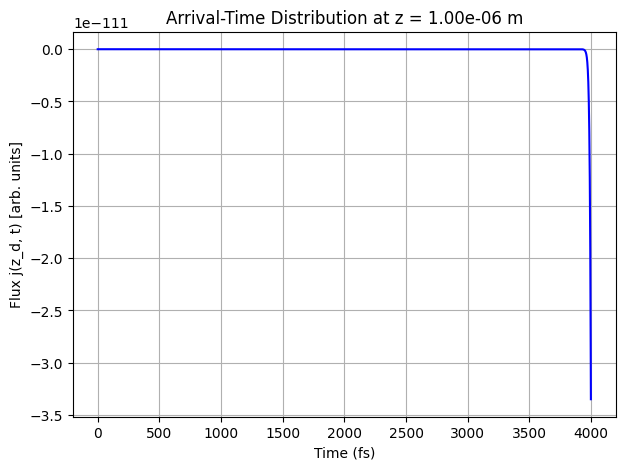

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------------------------------------
# 1. Physical & Numerical Parameters
# ------------------------------------------------------------------------------

hbar = 1.054571817e-34      # Planck's constant / 2π (J·s)
m    = 9.10938356e-31       # mass of the particle (e.g., electron mass) in kg
g    = 9.81                  # gravitational acceleration (m/s^2)

# Domain settings (z in meters):
z_min, z_max = 0.0, 1.0e-6   # from 0 to 1 micron, for instance
Nz = 1024                    # number of spatial grid points
dz = (z_max - z_min) / (Nz - 1)
z_vals = np.linspace(z_min, z_max, Nz)

# Time stepping
dt = 1.0e-15                 # time step (seconds) - pick small enough for stability
N_steps = 4000               # number of time steps

# Potential barrier parameters (Gaussian)
V0     = 1.0e-20             # height of the Gaussian barrier (Joules)
z0     = 5.0e-7              # center of the barrier (m)
sigma  = 1.0e-8              # width of the barrier (m)

# Detector/screen position
z_detector = 2          # measure flux at z = 0.8 micron

# Initial wave packet parameters
z_init     = 2.0e-7          # center of the initial wave packet (above barrier)
sigma0     = 2.0e-8          # initial width of the wave packet
p0         = 0.0             # near-zero initial momentum (in kg·m/s)

# ------------------------------------------------------------------------------
# 2. Construct the Potential Array:  V(z) = mgz + Gaussian barrier
# ------------------------------------------------------------------------------

# Gravitational potential: mgz
V_gravity = m * g * z_vals

# Gaussian barrier
V_gauss = V0 * np.exp(-((z_vals - z0)**2) / (2.0 * sigma**2))

# Total potential
V = V_gravity + V_gauss

# ------------------------------------------------------------------------------
# 3. Initialize the Wavefunction Psi(z, 0)
#    A Gaussian wave packet localized at z_init with (approx) zero momentum
# ------------------------------------------------------------------------------

def gaussian_wave_packet(z, z0, sigma0, p0, hbar):
    """
    Returns the value of a Gaussian wave packet with center z0,
    width sigma0, and average momentum p0.
    """
    norm_factor = (1.0 / (2.0 * np.pi * sigma0**2))**0.25
    # Phase factor for momentum p0
    phase = np.exp(1j * p0 * (z - z0) / hbar)
    envelope = np.exp(-0.5 * ((z - z0) / sigma0)**2)
    return norm_factor * envelope * phase

psi = gaussian_wave_packet(z_vals, z_init, sigma0, p0, hbar)

# Normalize the wavefunction
def normalize(psi, dz):
    norm = np.sqrt(np.sum(np.abs(psi)**2) * dz)
    return psi / norm

psi = normalize(psi, dz)

# ------------------------------------------------------------------------------
# 4. Construct Crank–Nicolson Matrices
#    We solve:  (1 + i*dt*H/2hbar) Psi^{n+1} = (1 - i*dt*H/2hbar) Psi^{n}
# ------------------------------------------------------------------------------

# Kinetic energy operator (in 1D):
# T = - (hbar^2 / 2m) * d^2/dz^2
# We approximate the second derivative with finite differences.

alpha = 1j * dt / (2.0 * hbar)  # factor in front of H

# Diagonal and off-diagonal elements for the finite-difference Laplacian
# Laplacian approx: psi''(z) ~ [psi(z+dz) - 2psi(z) + psi(z-dz)] / dz^2
# => T * psi(z) ~ - (hbar^2 / (2m)) * Laplacian

kin_const = - (hbar**2) / (2.0 * m * dz**2)

# Build the main diagonal and off-diagonals for the Hamiltonian:
# H = T + V.

# We'll build arrays for a banded system: A * psi^{n+1} = B * psi^n
# where A = (I + alpha H) and B = (I - alpha H).

diag_kin = 2.0 * kin_const  # coefficient for -2 * psi(z)
off_kin  = kin_const        # coefficient for +1 * psi(z +/- 1)

# Precompute diagonal terms: V + 2*kin_const
H_diag = V + diag_kin

# Arrays for the tridiagonal matrix
# A = 1 + alpha * H
# B = 1 - alpha * H
# => For each diagonal element: 1 + alpha * H_diag[i]
#    Off-diagonal: - alpha * off_kin
A_diag = np.ones(Nz, dtype=np.complex128)
B_diag = np.ones(Nz, dtype=np.complex128)
A_off  = np.zeros(Nz-1, dtype=np.complex128)
B_off  = np.zeros(Nz-1, dtype=np.complex128)

for i in range(Nz):
    A_diag[i] = 1.0 + alpha * H_diag[i]
    B_diag[i] = 1.0 - alpha * H_diag[i]

for i in range(Nz-1):
    A_off[i] = - alpha * off_kin
    B_off[i] = + alpha * off_kin

# We will update these A and B at each timestep if the potential is time-dependent.
# Here, V is time-independent, so we can build them once.

# ------------------------------------------------------------------------------
# 5. Helper Functions for Tridiagonal Solve (Crank–Nicolson Step)
# ------------------------------------------------------------------------------

def crank_nicolson_step(psi_n, A_diag, A_off, B_diag, B_off):
    """
    Performs one Crank–Nicolson update:
       A * psi^{n+1} = B * psi^n
    where A and B are tridiagonal matrices encoded by diag/off-diag arrays.
    We solve for psi^{n+1} using a standard tridiagonal solver.
    """
    # Compute the RHS: B * psi^n
    # B is also tridiagonal with diagonals B_diag, off-diagonals B_off
    rhs = apply_tridiagonal(B_diag, B_off, psi_n)
    
    # Solve A x = rhs for x = psi^{n+1}, with A tridiagonal
    psi_np1 = solve_tridiagonal(A_diag, A_off, rhs)
    return psi_np1

def apply_tridiagonal(d, od, x):
    """
    Apply a tridiagonal matrix with diagonal d and off-diagonal od
    to vector x.
    """
    _Nx = len(x)
    y = np.zeros(_Nx, dtype=np.complex128)
    # y[i] = d[i]*x[i] + od[i-1]*x[i-1] + od[i]*x[i+1]  (watch boundaries)
    y[0]     = d[0]*x[0]     + od[0]*x[1]
    y[_Nx-1]  = od[_Nx-2]*x[_Nx-2] + d[_Nx-1]*x[_Nx-1]
    for i in range(1, _Nx-1):
        y[i] = od[i-1]*x[i-1] + d[i]*x[i] + od[i]*x[i+1]
    return y

def solve_tridiagonal(d, od, b):
    """
    Solve the tridiagonal system:
       M x = b
    where M has diagonal d and off-diagonal od.  We can use the
    Thomas algorithm here.
    """
    N = len(d)
    # c' array (modified off diag), and solution x
    c_prime = np.zeros(N-1, dtype=np.complex128)
    x       = np.zeros(N,   dtype=np.complex128)

    # Forward pass
    c_prime[0] = od[0] / d[0]
    for i in range(1, N-1):
        denom = d[i] - od[i-1] * c_prime[i-1]
        c_prime[i] = od[i] / denom

    # Modify b
    b_dash = np.zeros(N, dtype=np.complex128)
    b_dash[0] = b[0] / d[0]
    for i in range(1, N):
        denom = d[i] - od[i-1] * c_prime[i-1] if i-1 < N-1 else d[i]
        b_dash[i] = (b[i] - od[i-1] * b_dash[i-1]) / denom

    # Backward pass
    x[N-1] = b_dash[N-1]
    for i in range(N-2, -1, -1):
        x[i] = b_dash[i] - c_prime[i] * x[i+1]

    return x

# ------------------------------------------------------------------------------
# 6. Probability Current (Flux) and Arrival-Time Distribution
#    j(z, t) = (hbar / m) * Im[ psi^*(z,t) * d(psi(z,t))/dz ]
# ------------------------------------------------------------------------------

def probability_current(psi, dz, z_idx):
    """
    Compute the probability current j at grid index z_idx
    using a central-difference for d(psi)/dz at that point.
    """
    # If z_idx is at a boundary, handle carefully. For demonstration, 
    # do a simple finite difference inside the domain:
    if z_idx == 0:
        dpsi_dz = (psi[z_idx+1] - psi[z_idx]) / dz
    elif z_idx == len(psi)-1:
        dpsi_dz = (psi[z_idx] - psi[z_idx-1]) / dz
    else:
        dpsi_dz = (psi[z_idx+1] - psi[z_idx-1]) / (2.0*dz)

    # j = (ħ/m) * Im(psi^* dpsi/dz)
    val = (hbar / m) * np.imag(np.conjugate(psi[z_idx]) * dpsi_dz)
    return val

# Find the nearest grid point to the detector
z_d_idx = np.argmin(np.abs(z_vals - z_detector))

# ------------------------------------------------------------------------------
# 7. Time Evolution Loop
# ------------------------------------------------------------------------------

time_array = np.arange(0, N_steps*dt, dt)
flux_at_screen = np.zeros(N_steps, dtype=float)

for n in range(N_steps):
    # Record flux at the detector
    flux_at_screen[n] = probability_current(psi, dz, z_d_idx)

    # Crank–Nicolson step
    psi_new = crank_nicolson_step(psi, A_diag, A_off, B_diag, B_off)

    # Optional: normalize again (or skip if you prefer strictly unitary evolution).
    # In an ideal scenario with no absorbing boundary, total probability is conserved.
    # However, for numerical stability, some re-normalization might be useful.
    # psi_new = normalize(psi_new, dz)

    psi = psi_new

# ------------------------------------------------------------------------------
# 8. Plot the Arrival-Time Distribution
# ------------------------------------------------------------------------------

plt.figure(figsize=(7,5))
plt.plot(time_array*1e15, flux_at_screen, 'b-')
plt.xlabel('Time (fs)')  # 1 fs = 1e-15 s
plt.ylabel('Flux j(z_d, t) [arb. units]')
plt.title('Arrival-Time Distribution at z = {:.2e} m'.format(z_vals[z_d_idx]))
plt.grid(True)
plt.show()


## New Attempt

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# --- Physical & Numerical parameters (example) ---
hbar = 1.054571817e-34
m    = 9.10938356e-31
g    = 0.0            # gravity off for clarity
z_min, z_max = 0.0, 1.0e-6
Nz = 1024
dz = (z_max - z_min)/(Nz - 1)
z_vals = np.linspace(z_min, z_max, Nz)

dt = 1.0e-16
N_steps = 20000

# --- Potential: Gaussian barrier ---
V0    = 0 # 1.0e-19
z0    = 5.0e-7
sigma = 5.0e-8

V_gauss = V0 * np.exp(-((z_vals - z0)**2)/(2.0*sigma**2))
V = V_gauss  # ignoring mgz for demonstration

# --- Initial wave packet ---
z_init = 3.0e-7
sigma0 = 3.0e-8
p0     = 1.0e-24

def gaussian_wave_packet(z, z0, sigma0, p0, hbar):
    norm = (1.0/(2.0*np.pi*sigma0**2))**0.25
    phase = np.exp(1j*p0*(z - z0)/hbar)
    envelope = np.exp(-0.5 * ((z - z0)/sigma0)**2)
    return norm * envelope * phase

psi = gaussian_wave_packet(z_vals, z_init, sigma0, p0, hbar)

# Normalize
def normalize(psi, dz):
    norm_factor = np.sqrt(np.sum(np.abs(psi)**2)*dz)
    return psi / norm_factor

psi = normalize(psi, dz)

# --- Crank–Nicolson Setup ---
alpha = 1j*dt/(2*hbar)

# Kinetic operator: T = -(hbar^2/(2m)) d^2/dz^2
kin_const = - (hbar**2)/(2*m*dz**2)

diag_kin = 2.0*kin_const
off_kin  = kin_const

H_diag = V + diag_kin
A_diag = np.ones(Nz, dtype=np.complex128)
B_diag = np.ones(Nz, dtype=np.complex128)
A_off  = np.zeros(Nz-1, dtype=np.complex128)
B_off  = np.zeros(Nz-1, dtype=np.complex128)

for i in range(Nz):
    A_diag[i] = 1.0 + alpha*H_diag[i]
    B_diag[i] = 1.0 - alpha*H_diag[i]
for i in range(Nz-1):
    A_off[i] = - alpha*off_kin
    B_off[i] = + alpha*off_kin

def apply_tridiagonal(d, od, x):
    Nx = len(x)
    y = np.zeros_like(x, dtype=np.complex128)
    y[0] = d[0]*x[0] + od[0]*x[1]
    for i in range(1, Nx-1):
        y[i] = od[i-1]*x[i-1] + d[i]*x[i] + od[i]*x[i+1]
    y[Nx-1] = od[Nx-2]*x[Nx-2] + d[Nx-1]*x[Nx-1]
    return y

def solve_tridiagonal(d, od, b):
    N = len(d)
    c_prime = np.zeros(N-1, dtype=np.complex128)
    x = np.zeros(N, dtype=np.complex128)

    c_prime[0] = od[0]/d[0]
    for i in range(1, N-1):
        denom = d[i] - od[i-1]*c_prime[i-1]
        c_prime[i] = od[i]/denom

    b_dash = np.zeros_like(b, dtype=np.complex128)
    b_dash[0] = b[0]/d[0]
    for i in range(1, N):
        denom = d[i] - od[i-1]*c_prime[i-1] if i-1 < N-1 else d[i]
        b_dash[i] = (b[i] - od[i-1]*b_dash[i-1]) / denom

    x[N-1] = b_dash[N-1]
    for i in range(N-2, -1, -1):
        x[i] = b_dash[i] - c_prime[i]*x[i+1]
    return x

def crank_nicolson_step(psi_n):
    rhs = apply_tridiagonal(B_diag, B_off, psi_n)
    psi_np1 = solve_tridiagonal(A_diag, A_off, rhs)
    return psi_np1

# --- Store psi(t) for each time step ---
psi_all = np.zeros((N_steps, Nz), dtype=np.complex128)
psi_all[0, :] = psi

for n in range(1, N_steps):
    psi = crank_nicolson_step(psi)
    # Optionally re-normalize or not:
    # psi = normalize(psi, dz)
    psi_all[n, :] = psi

# --- Now we have psi_all. Make a 2D array for probability density ---
#     prob[t, i] = |psi_all[t, i]|^2
prob = np.abs(psi_all)**2

# We also create a time array for convenience
t_vals = np.arange(N_steps)*dt


heatmap of |psi|^2

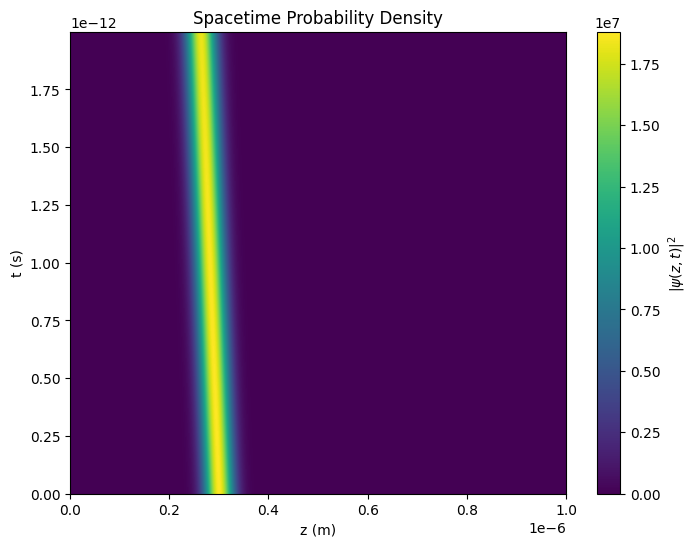

In [26]:
plt.figure(figsize=(8,6))

# We want z to go along x-axis, time along y-axis
# so prob is indexed as prob[time_idx, space_idx]
# "extent" = [x_min, x_max, y_min, y_max]
# By default, imshow sets (0,0) in the top-left corner, so we might want origin='lower'
# to have t=0 at bottom, t increasing upward.

plt.imshow(prob, 
           extent=[z_min, z_max, t_vals[0], t_vals[-1]],
           aspect='auto', 
           cmap='viridis',
           origin='lower'
          )

plt.colorbar(label=r'$|\psi(z,t)|^2$')
plt.xlabel('z (m)')
plt.ylabel('t (s)')
plt.title('Spacetime Probability Density')
plt.show()


Overlay potential


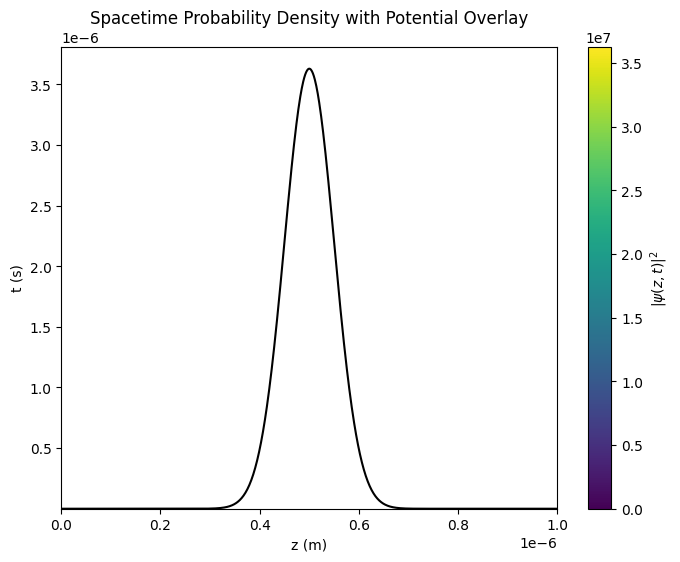

In [6]:
# Let's overlay a line for V(z). We'll re-scale it 
# so it fits on the same color scale or just plot a white line 
# on top of the heatmap by mapping V to some range.

# For example, let's define a potential scaled to 0..max(prob)
V_scaled = (V - np.min(V)) / (np.max(V) - np.min(V)) * np.max(prob)

# We just plot a line at t=0.5 ps, for instance, to see the shape
t_overlay = 0.5e-12  # 0.5 ps
plt.figure(figsize=(8,6))
plt.imshow(prob, 
           extent=[z_min, z_max, t_vals[0], t_vals[-1]],
           aspect='auto', 
           cmap='viridis',
           origin='lower'
          )

# convert t_overlay to the same "pixel coordinate" in imshow space
# i.e. fraction from t_vals[0] to t_vals[-1]
# or we can just plot using standard axes and let them overlay.

z_overlay = z_vals
plt.plot(z_overlay, np.full_like(z_overlay, t_overlay), 'w--') # horizontal line
plt.plot(z_overlay, (t_overlay + 0.0000000000001*(V_scaled)), 'k')  # tiny offset?

# Actually, a simpler approach is to "map time -> some function of V"
# That can get tricky. Often it's easier to do a 2D figure: 
# color = prob, brightness or contour lines = potential

plt.colorbar(label=r'$|\psi(z,t)|^2$')
plt.xlabel('z (m)')
plt.ylabel('t (s)')
plt.title('Spacetime Probability Density with Potential Overlay')
plt.show()


So perhaps the potential is just too high right now

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# --- Physical & Numerical parameters (example) ---
hbar = 1.054571817e-34
m    = 9.10938356e-31
g    = -10*8.987551787368176e16            # gravity off for clarity
z_min, z_max = 0.0, 1.0e-6
Nz = 1024
dz = (z_max - z_min)/(Nz - 1)
z_vals = np.linspace(z_min, z_max, Nz)

dt = 1.0e-1
N_steps = 40000

# --- Potential: Gaussian barrier ---
V0    = 1.0e-14
z0    = 5.0e-7
sigma = 5.0e-8

V_gauss = V0 * np.exp(-((z_vals - z0)**2)/(2.0*sigma**2))
V = V_gauss  # ignoring mgz for demonstration

# --- Initial wave packet ---
z_init = 3.0e-7
sigma0 = 3.0e-8
p0     = 1.0e-24

def gaussian_wave_packet(z, z0, sigma0, p0, hbar):
    norm = (1.0/(2.0*np.pi*sigma0**2))**0.25
    phase = np.exp(1j*p0*(z - z0)/hbar)
    envelope = np.exp(-0.5 * ((z - z0)/sigma0)**2)
    return norm * envelope * phase

psi = gaussian_wave_packet(z_vals, z_init, sigma0, p0, hbar)

# Normalize
def normalize(psi, dz):
    norm_factor = np.sqrt(np.sum(np.abs(psi)**2)*dz)
    return psi / norm_factor

psi = normalize(psi, dz)

# --- Crank–Nicolson Setup ---
alpha = 1j*dt/(2*hbar)

# Kinetic operator: T = -(hbar^2/(2m)) d^2/dz^2
kin_const = - (hbar**2)/(2*m*dz**2)

diag_kin = 2.0*kin_const
off_kin  = kin_const

H_diag = V + diag_kin
A_diag = np.ones(Nz, dtype=np.complex128)
B_diag = np.ones(Nz, dtype=np.complex128)
A_off  = np.zeros(Nz-1, dtype=np.complex128)
B_off  = np.zeros(Nz-1, dtype=np.complex128)

for i in range(Nz):
    A_diag[i] = 1.0 + alpha*H_diag[i]
    B_diag[i] = 1.0 - alpha*H_diag[i]
for i in range(Nz-1):
    A_off[i] = - alpha*off_kin
    B_off[i] = + alpha*off_kin

def apply_tridiagonal(d, od, x):
    Nx = len(x)
    y = np.zeros_like(x, dtype=np.complex128)
    y[0] = d[0]*x[0] + od[0]*x[1]
    for i in range(1, Nx-1):
        y[i] = od[i-1]*x[i-1] + d[i]*x[i] + od[i]*x[i+1]
    y[Nx-1] = od[Nx-2]*x[Nx-2] + d[Nx-1]*x[Nx-1]
    return y

def solve_tridiagonal(d, od, b):
    N = len(d)
    c_prime = np.zeros(N-1, dtype=np.complex128)
    x = np.zeros(N, dtype=np.complex128)

    c_prime[0] = od[0]/d[0]
    for i in range(1, N-1):
        denom = d[i] - od[i-1]*c_prime[i-1]
        c_prime[i] = od[i]/denom

    b_dash = np.zeros_like(b, dtype=np.complex128)
    b_dash[0] = b[0]/d[0]
    for i in range(1, N):
        denom = d[i] - od[i-1]*c_prime[i-1] if i-1 < N-1 else d[i]
        b_dash[i] = (b[i] - od[i-1]*b_dash[i-1]) / denom

    x[N-1] = b_dash[N-1]
    for i in range(N-2, -1, -1):
        x[i] = b_dash[i] - c_prime[i]*x[i+1]
    return x

def crank_nicolson_step(psi_n):
    rhs = apply_tridiagonal(B_diag, B_off, psi_n)
    psi_np1 = solve_tridiagonal(A_diag, A_off, rhs)
    return psi_np1

# --- Store psi(t) for each time step ---
psi_all = np.zeros((N_steps, Nz), dtype=np.complex128)
psi_all[0, :] = psi

for n in range(1, N_steps):
    psi = crank_nicolson_step(psi)
    # Optionally re-normalize or not:
    # psi = normalize(psi, dz)
    psi_all[n, :] = psi

# --- Now we have psi_all. Make a 2D array for probability density ---
#     prob[t, i] = |psi_all[t, i]|^2
prob = np.abs(psi_all)**2

# We also create a time array for convenience
t_vals = np.arange(N_steps)*dt


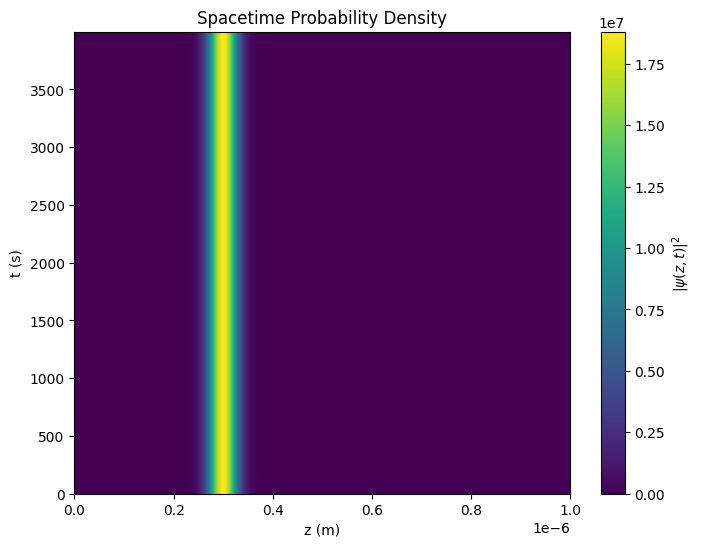

In [37]:
plt.figure(figsize=(8,6))

# We want z to go along x-axis, time along y-axis
# so prob is indexed as prob[time_idx, space_idx]
# "extent" = [x_min, x_max, y_min, y_max]
# By default, imshow sets (0,0) in the top-left corner, so we might want origin='lower'
# to have t=0 at bottom, t increasing upward.

plt.imshow(prob, 
           extent=[z_min, z_max, t_vals[0], t_vals[-1]],
           aspect='auto', 
           cmap='viridis',
           origin='lower'
          )

plt.colorbar(label=r'$|\psi(z,t)|^2$')
plt.xlabel('z (m)')
plt.ylabel('t (s)')
plt.title('Spacetime Probability Density')
plt.show()


## A now approach - 18 January 2024



In [5]:
import numpy as np
import matplotlib.pyplot as plt

# For convenience, we'll define some units:
hbar = 1.0     # reduced Planck constant
m = 1.0        # mass
g = 1.0        # gravitational acceleration

# We'll choose a 1D spatial domain:
z_min, z_max = -20.0, 20.0  # space range
N_z = 512                   # number of spatial points

# Time-stepping:
dt = 0.01   # time step
N_t = 1500  # number of time steps (change for longer/shorter evolution)


In [6]:
def kinetic_phase_factor(k, dt):
    """
    Returns the factor exp(-i * hbar*k^2/(2m) * dt / hbar)
    = exp(-i * k^2 * dt / (2m))
    where k is the wave number array.
    """
    return np.exp(-0.5j * (hbar * k**2 / (2*m)) * (dt / hbar) * 2)

def gravity_potential(z):
    """ Gravity potential: V = m*g*z. """
    return m*g*z

def delta_barrier(z, z0=0.0, alpha=5.0, dz=0.01):
    """
    Numerically approximate a delta potential by placing a narrow spike
    at z = z0. 'alpha' sets the strength. 'dz' is the approximate width.
    
    For a true delta, V(z) = alpha * delta(z - z0).
    Numerically, we can approximate as a very narrow Gaussian or a top-hat.
    """
    # Narrow Gaussian approximation:
    sigma = dz / 2
    return alpha * np.exp(-((z - z0)**2) / (2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def gaussian_barrier(z, z0=0.0, V0=5.0, sigma=0.5):
    """
    A Gaussian potential barrier centered at z0 with height ~ V0
    and width ~ sigma.
    """
    return V0 * np.exp(-(z - z0)**2 / (2*sigma**2))

def initial_wavefunction(z, z0=10.0, p0=0.0, sigma0=1.0):
    """
    Initialize a Gaussian wave packet:
        psi(z) = (1/(2*pi*sigma0^2))^(1/4) * exp(-(z-z0)^2/(4 sigma0^2)) * exp(i p0 (z-z0)/hbar).
    """
    norm_factor = 1.0 / (2.0 * np.pi * sigma0**2)**0.25
    return norm_factor * np.exp(-(z - z0)**2 / (4.0 * sigma0**2)) \
                       * np.exp(1j * p0 * (z - z0) / hbar)


In [8]:
def split_operator_step(psi, V, kinetic_factor):
    # 1. Half-step potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    
    # 2. Kinetic step in momentum space
    psi_k = np.fft.fft(psi)          # forward FFT
    psi_k *= kinetic_factor          # multiply by kinetic phase factor
    psi = np.fft.ifft(psi_k)         # inverse FFT
    
    # 3. Another half-step potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    
    return psi


In [7]:
def run_simulation(barrier_func, 
                   z_array, 
                   z0_barrier=0.0, 
                   barrier_params={}, 
                   psi_init=None, 
                   n_steps=N_t, 
                   dt_val=dt, 
                   store_steps=[0, 300, 600, 900, 1200, 1499]):
    """
    barrier_func(z, **barrier_params) -> potential array for the barrier
    z_array -> spatial grid
    psi_init -> initial wavefunction
    store_steps -> which time steps to store (for plotting).
    
    Returns: stored_times, stored_psi, final_psi
    """
    # Potential = gravity + barrier
    V_barrier = barrier_func(z_array, **barrier_params)
    V_total = gravity_potential(z_array) + V_barrier

    # Prepare wavefunction
    if psi_init is None:
        # By default, place the wave packet above the barrier
        psi = initial_wavefunction(z_array, z0=10.0)
    else:
        psi = psi_init.copy()

    # Create wave number array for kinetic factor
    dz = z_array[1] - z_array[0]
    k_array = 2.0 * np.pi * np.fft.fftfreq(len(z_array), d=dz)
    kinetic_factor = np.exp(-0.5j * (hbar * k_array**2 / (2*m)) * (dt_val / hbar) * 2)

    # For storing results
    stored_psi = []
    stored_times = []

    for step in range(n_steps):
        # store wavefunction if step in store_steps
        if step in store_steps:
            stored_psi.append(psi.copy())
            stored_times.append(step * dt_val)

        # do split-operator step
        psi = split_operator_step(psi, V_total, kinetic_factor)
    
    # store final wavefunction
    if n_steps-1 not in store_steps:
        stored_psi.append(psi.copy())
        stored_times.append((n_steps-1) * dt_val)

    return np.array(stored_times), stored_psi, psi


Plot results please

In [28]:
def plot_results(z_array, 
                 t_delta, psi_stored_delta, 
                 t_gauss, psi_stored_gauss,
                 delta_params, gauss_params,
                 z_detector=-10.0):
    fig, axs = plt.subplots(2, 3, figsize=(16,8))
    fig.suptitle("Comparison: Delta-like Barrier vs Gaussian Barrier", fontsize=16)
    
    # 1. Plot potentials for reference
    V_delta_approx = delta_barrier(z_array, **delta_params)
    V_gauss = gaussian_barrier(z_array, **gauss_params)
    V_grav = gravity_potential(z_array)
    
    axs[0,0].plot(z_array, V_grav + V_delta_approx, label="Delta Approx + Gravity")
    axs[0,0].set_title("Total Potential (Delta Approx)")
    axs[0,0].set_xlabel("z")
    axs[0,0].set_ylabel("V(z)")
    axs[0,0].legend()
    
    axs[1,0].plot(z_array, V_grav + V_gauss, label="Gaussian + Gravity", color="orange")
    axs[1,0].set_title("Total Potential (Gaussian)")
    axs[1,0].set_xlabel("z")
    axs[1,0].set_ylabel("V(z)")
    axs[1,0].legend()

    # 2. Wavefunction snapshots: let's show probability densities at selected times
    #    For the delta case in the top row, gaussian case in bottom row
    # pick a particular set of snapshots
    snapshot_indices = range(0, 1000, 100) # up to 4 snapshots, for example
    
    for i, idx in enumerate(snapshot_indices):
        psi_delta = psi_stored_delta[idx]
        prob_delta = np.abs(psi_delta)**2
        time_delta = t_delta[idx]
        axs[0,1].plot(z_array, prob_delta, label=f"t={time_delta:.2f}")

    axs[0,1].set_title("Wavefunction (Delta) Snapshots")
    axs[0,1].set_xlabel("z")
    axs[0,1].set_ylabel("|psi(z)|^2")
    axs[0,1].legend()

    for i, idx in enumerate(snapshot_indices):
        psi_gauss = psi_stored_gauss[idx]
        prob_gauss = np.abs(psi_gauss)**2
        time_gauss = t_gauss[idx]
        axs[1,1].plot(z_array, prob_gauss, label=f"t={time_gauss:.2f}")
        
    axs[1,1].set_title("Wavefunction (Gaussian) Snapshots")
    axs[1,1].set_xlabel("z")
    axs[1,1].set_ylabel("|psi(z)|^2")
    axs[1,1].legend()

    # 3. Compute flux J at z_detector as a function of time
    #    We'll do a quick function to compute J from wavefunction.
    def probability_flux(psi, z_array):
        """
        Approx flux at a single point: 
        J = (hbar/m)*Im(psi^* dpsi/dz).
        We'll do a finite difference near z_detector.
        """
        dz = z_array[1] - z_array[0]
        # Index near z_detector
        idx_det = np.argmin(np.abs(z_array - z_detector))
        # central difference
        dpsi_dz = (psi[idx_det+1] - psi[idx_det-1])/(2*dz)
        val = (hbar/m)*np.imag(np.conjugate(psi[idx_det]) * dpsi_dz)
        return val
    
    # Evaluate flux for each stored wavefunction
    flux_delta_times = []
    flux_delta_vals = []
    for i, tval in enumerate(t_delta):
        flux_val = probability_flux(psi_stored_delta[i], z_array)
        flux_delta_times.append(tval)
        flux_delta_vals.append(flux_val)

    flux_gauss_times = []
    flux_gauss_vals = []
    for i, tval in enumerate(t_gauss):
        flux_val = probability_flux(psi_stored_gauss[i], z_array)
        flux_gauss_times.append(tval)
        flux_gauss_vals.append(flux_val)
    
    axs[0,2].plot(flux_delta_times, flux_delta_vals, label="Delta flux at z_det")
    axs[0,2].set_title("Flux vs time (Delta Barrier)")
    axs[0,2].set_xlabel("time")
    axs[0,2].set_ylabel("J(z_det, t)")
    axs[0,2].legend()

    axs[1,2].plot(flux_gauss_times, flux_gauss_vals, label="Gaussian flux at z_det", color="orange")
    axs[1,2].set_title("Flux vs time (Gaussian Barrier)")
    axs[1,2].set_xlabel("time")
    axs[1,2].set_ylabel("J(z_det, t)")
    axs[1,2].legend()
    
    plt.tight_layout()
    plt.show()

IndexError: list index out of range

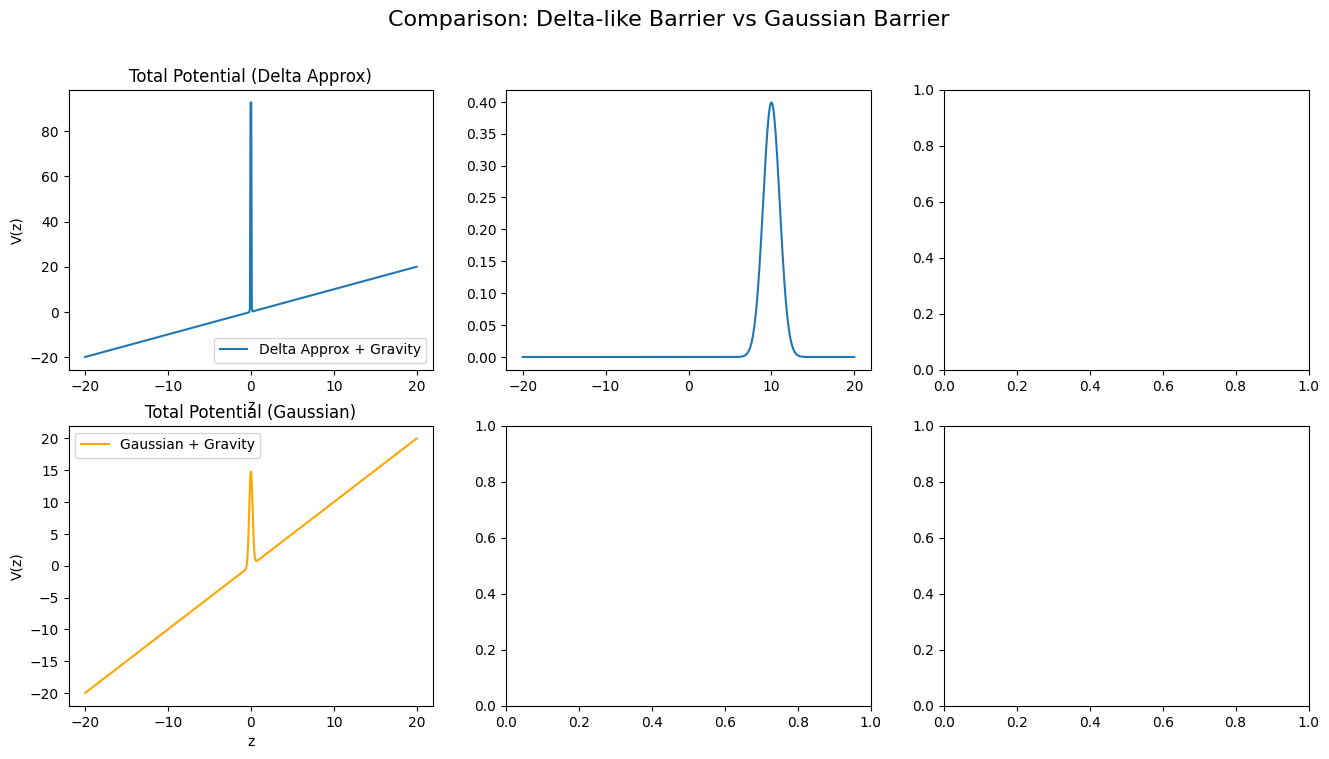

In [30]:
def main():
    # 1. Create spatial grid
    z_array = np.linspace(z_min, z_max, N_z)
    
    # 2. Delta barrier simulation
    #    We'll approximate the delta with a narrow Gaussian spike
    #    alpha => "strength" of barrier
    #    We'll keep z0_barrier=0 for demonstration
    delta_params = {'z0': 0.0, 'alpha': 15.0, 'dz': (z_max - z_min)/N_z}
    t_delta, psi_stored_delta, psi_final_delta = run_simulation(
        barrier_func=delta_barrier,
        z_array=z_array,
        barrier_params=delta_params,
        store_steps=range(0, 1000, 100)
    )
    
    # 3. Gaussian barrier simulation
    gauss_params = {'z0': 0.0, 'V0': 15.0, 'sigma': 0.2}
    t_gauss, psi_stored_gauss, psi_final_gauss = run_simulation(
        barrier_func=gaussian_barrier,
        z_array=z_array,
        barrier_params=gauss_params,
        store_steps=np.arange(0, 1000, 100)
    )

    # 4. Plot results
    plot_results(z_array, t_delta, psi_stored_delta, t_gauss, psi_stored_gauss, 
                 delta_params, gauss_params)

if __name__ == '__main__':
    main()


In [47]:
def main():
    # 1. Create spatial grid
    z_array = np.linspace(z_min, z_max, N_z)
    
    # 2. Delta barrier simulation
    #    We'll approximate the delta with a narrow Gaussian spike
    #    alpha => "strength" of barrier
    #    We'll keep z0_barrier=0 for demonstration
    delta_params = {'z0': 0.0, 'alpha': 25.0, 'dz': (z_max - z_min)/N_z}
    t_delta, psi_stored_delta, psi_final_delta = run_simulation(
        barrier_func=delta_barrier,
        z_array=z_array,
        barrier_params=delta_params,
        store_steps=[0, 200, 400, 800, 1400, 1800]
    )
    
    # 3. Gaussian barrier simulation
    gauss_params = {'z0': 0.0, 'V0': 25.0, 'sigma': 0.5}
    t_gauss, psi_stored_gauss, psi_final_gauss = run_simulation(
        barrier_func=gaussian_barrier,
        z_array=z_array,
        barrier_params=gauss_params,
        store_steps=[0, 200, 400, 800, 1400, 1800, 2000, 3000]
    )

    # 4. Plot results
    plot_results(z_array, t_delta, psi_stored_delta, t_gauss, psi_stored_gauss, 
                 delta_params, gauss_params)

if __name__ == '__main__':
    main()


TypeError: split_operator_step() missing 1 required positional argument: 'dt'

Adding animation creator

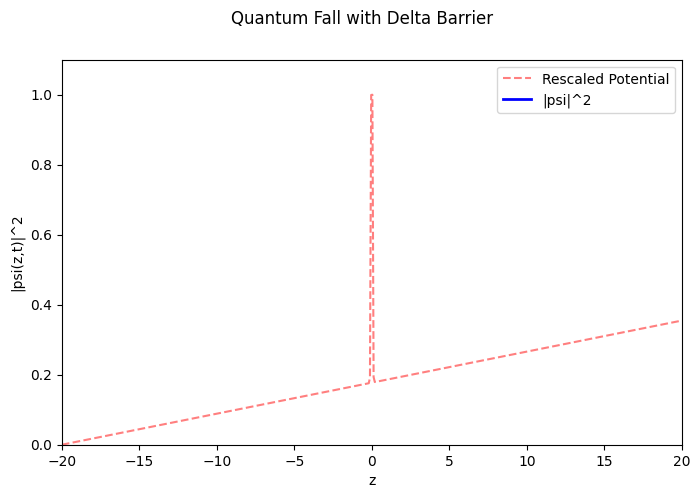

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

hbar = 1.0
m = 1.0
g = 1.0

def gravity_potential(z):
    return m * g * z

def delta_barrier(z, z0=0.0, alpha=5.0, dz=0.01):
    # Narrow Gaussian approximation of delta
    sigma = dz / 2
    return alpha * np.exp(-((z - z0)**2) / (2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def gaussian_barrier(z, z0=0.0, V0=5.0, sigma=0.5):
    return V0 * np.exp(-(z - z0)**2 / (2*sigma**2))

def initial_wavefunction(z, z0=10.0, p0=0.0, sigma0=1.0):
    norm_factor = 1.0 / (2.0 * np.pi * sigma0**2)**0.25
    return norm_factor * np.exp(-(z - z0)**2 / (4.0 * sigma0**2)) \
                       * np.exp(1j * p0 * (z - z0) / hbar)

def split_operator_step(psi, V, kinetic_factor, dt):
    """One time-step of the split-operator method."""
    # half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    # full-step in kinetic (momentum) space
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_factor
    psi = np.fft.ifft(psi_k)
    # half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    return psi

def simulate_n(barrier_type='delta', 
               n_steps=200, 
               dt=0.01, 
               x_min=-20, x_max=20, Nx=512,
               barrier_params=None,
               z0_packet=10.0):
    """
    Simulate for `n_steps` steps using split-operator, then produce an animation
    of |psi(z,t)|^2 vs. z. Returns the animation object (FuncAnimation).
    
    barrier_type: 'delta' or 'gaussian'
    barrier_params: dict with barrier parameters
    """
    if barrier_params is None:
        barrier_params = {}

    # 1) Prepare spatial grid
    z_array = np.linspace(x_min, x_max, Nx)
    dz = z_array[1] - z_array[0]
    
    # 2) Build total potential V(z)
    if barrier_type == 'delta':
        V_bar = delta_barrier(z_array, **barrier_params, dz=dz)
    else:
        V_bar = gaussian_barrier(z_array, **barrier_params)
    V_total = gravity_potential(z_array) + V_bar

    # 3) Build kinetic phase factor in momentum space
    k_array = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dz)
    # exponent = - i dt / hbar * (hbar^2 k^2 / (2m)) = - i dt * (hbar k^2 / (2m))
    kinetic_factor = np.exp(-0.5j * (hbar * k_array**2 / (2*m)) * (dt / hbar) * 2)

    # 4) Initialize wavefunction
    psi = initial_wavefunction(z_array, z0=z0_packet, p0=0.0)

    # 5) Set up figure & axis for animation
    fig, ax = plt.subplots(figsize=(8,5))
    fig.suptitle(f"Quantum Fall with {barrier_type.capitalize()} Barrier")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.1)  # might need dynamic scaling
    ax.set_xlabel("z")
    ax.set_ylabel("|psi(z,t)|^2")
    
    # Potential curve (rescaled for overlay)
    # e.g. we can plot  V(z) shifted & scaled so it fits in the [0,1] range, for reference:
    V_shift = V_total - np.min(V_total)
    V_norm = V_shift / np.max(V_shift + 1e-9)
    ax.plot(z_array, V_norm, 'r--', alpha=0.5, label="Rescaled Potential")

    # Plot the wavefunction magnitude squared:
    line_psi, = ax.plot([], [], 'b-', lw=2, label='|psi|^2')
    
    ax.legend(loc='upper right')
    
    # 6) Animation init & update
    def init():
        line_psi.set_data([], [])
        return (line_psi,)
    
    def update(frame):
        nonlocal psi
        # update wavefunction by one step
        psi = split_operator_step(psi, V_total, kinetic_factor, dt)
        prob = np.abs(psi)**2
        
        line_psi.set_data(z_array, prob)
        return (line_psi,)
    
    # 7) Create FuncAnimation
    anim = animation.FuncAnimation(
        fig, update, init_func=init,
        frames=n_steps, interval=50, blit=True
    )

    # 8) Return or save animation
    # Save as mp4 (requires ffmpeg) or show in Jupyter:
    # anim.save('quantum_fall.mp4', writer='ffmpeg', fps=20)
    return anim

if __name__ == "__main__":
    # Example usage:
    # simulate a 'delta' barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': 15.0}  # approximate delta
    anim_delta = simulate_n(barrier_type='delta',
                            n_steps=2000,
                            dt=0.001,
                            barrier_params=barrier_params_delta)
    
    # If you want to display in an interactive window:
    plt.show()

    # Or a Gaussian barrier
    # barrier_params_gauss = {'z0': 0.0, 'V0': 15.0, 'sigma': 0.2}
    # anim_gauss = simulate_n(barrier_type='gaussian',
    #                         n_steps=200,
    #                         dt=0.01,
    #                         barrier_params=barrier_params_gauss)
    # plt.show()


Saved quantum_fall_barrier_0.5_more_resolution.mp4


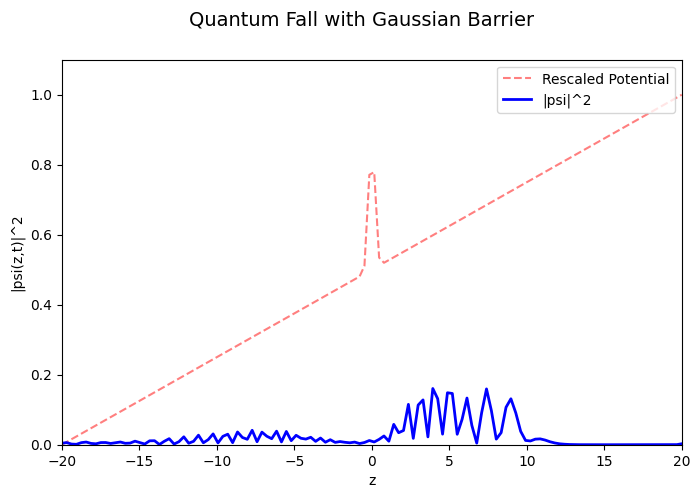

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

hbar = 1.0
m = 1.0
g = 1.0

def gravity_potential(z):
    return m * g * z

def delta_barrier(z, z0=0.0, alpha=5.0, dz=0.01):
    sigma = dz / 2
    return alpha * np.exp(-((z - z0)**2)/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def gaussian_barrier(z, z0=0.0, V0=5.0, sigma=0.5):
    return V0 * np.exp(-(z - z0)**2/(2*sigma**2))

def initial_wavefunction(z, z0=10.0, p0=0.0, sigma0=1.0):
    norm_factor = 1.0 / (2.0 * np.pi * sigma0**2)**0.25
    return (norm_factor
            * np.exp(-(z - z0)**2 / (4.0 * sigma0**2))
            * np.exp(1j * p0 * (z - z0) / hbar))

def split_operator_step(psi, V, kinetic_factor, dt):
    psi *= np.exp(-0.5j * V * dt / hbar)
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_factor
    psi = np.fft.ifft(psi_k)
    psi *= np.exp(-0.5j * V * dt / hbar)
    return psi

def simulate_n(barrier_type='delta', 
               n_steps=200, 
               dt=0.01, 
               x_min=-20, x_max=20, Nx=128,
               barrier_params=None,
               z0_packet=10.0):
    """
    Simulate for `n_steps` time steps using split-operator, then produce an animation
    of |psi(z,t)|^2 vs. z. Returns the animation object (FuncAnimation).
    """
    if barrier_params is None:
        barrier_params = {}

    # Create spatial grid
    z_array = np.linspace(x_min, x_max, Nx)
    dz = z_array[1] - z_array[0]

    # Build potential
    if barrier_type == 'delta':
        V_bar = delta_barrier(z_array, **barrier_params, dz=dz)
    else:
        V_bar = gaussian_barrier(z_array, **barrier_params)
    V_total = gravity_potential(z_array) + V_bar

    # Kinetic factor
    k_array = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dz)
    kinetic_factor = np.exp(-0.5j * (hbar * k_array**2 / (2*m)) * (dt / hbar) * 2)

    # Initial wavefunction
    psi = initial_wavefunction(z_array, z0=z0_packet, p0=0.0)

    # Figure & axis for animation
    fig, ax = plt.subplots(figsize=(8,5))
    fig.suptitle(f"Quantum Fall with {barrier_type.capitalize()} Barrier", fontsize=14)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(0, 1.1)  # adjust as needed
    ax.set_xlabel("z")
    ax.set_ylabel("|psi(z,t)|^2")

    # Rescale potential for overlay
    V_shift = V_total - np.min(V_total)
    V_norm = V_shift / np.max(V_shift + 1e-9)
    ax.plot(z_array, V_norm, 'r--', alpha=0.5, label="Rescaled Potential")

    line_psi, = ax.plot([], [], 'b-', lw=2, label='|psi|^2')
    ax.legend(loc='upper right')

    def init():
        line_psi.set_data([], [])
        return (line_psi,)

    def update(frame):
        nonlocal psi
        psi = split_operator_step(psi, V_total, kinetic_factor, dt)
        prob = np.abs(psi)**2
        line_psi.set_data(z_array, prob)
        return (line_psi,)

    anim = animation.FuncAnimation(
        fig, update, init_func=init,
        frames=n_steps, interval=50, blit=True
    )
    return anim

def main():
    # Example: run a simulation with a "delta" barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': 15.0}
    gauss_params = {'z0': 0.0, 'V0': 15.0, 'sigma': 0.2}
    anim_delta = simulate_n(
        barrier_type='gaussian',
        n_steps=600,
        dt=0.1,
        barrier_params=gauss_params,
        z0_packet=10.0
    )

    # Save the animation to MP4 (requires FFmpeg installed and in PATH)
    anim_delta.save('quantum_fall_gaussian_higher_barrier_0.2_more_resolution.mp4', writer='ffmpeg', fps=20)
    print("Saved quantum_fall_barrier_0.5_more_resolution.mp4")

    # Display in an interactive window (comment this out if you don't want a popup)
    # plt.show()

if __name__ == "__main__":
    main()


## Plotting of the potential and wavefunction using heatmap

In [52]:
import matplotlib.pyplot as plt

def plot_spacetime(prob_arr, z_array, t_vals):
    """
    Produce a heatmap of |psi(z,t)|^2 over space (x-axis) and time (y-axis).
    
    Parameters:
    -----------
    prob_arr : 2D numpy array, shape (N_time, N_space)
               prob_arr[i, j] = |psi(z_j, t_i)|^2
    z_array : 1D numpy array, shape (N_space,)
              spatial grid points
    t_vals  : 1D numpy array, shape (N_time,)
              time points corresponding to each row of prob_arr
    """
    
    z_min, z_max = z_array[0], z_array[-1]
    t_min, t_max = t_vals[0], t_vals[-1]
    
    plt.figure(figsize=(8,6))
    
    # By default, imshow places the (0,0) data index in the top-left corner.
    # We can flip that by setting origin='lower',
    # so time=0 is at the bottom of the figure, time increases upwards.
    #
    # aspect='auto' ensures that the image scales to fill the axes properly,
    # rather than forcing a 1:1 aspect ratio.
    
    plt.imshow(
        prob_arr,
        extent=[z_min, z_max, t_min, t_max],
        aspect='auto',
        cmap='viridis',
        origin='lower'
    )
    
    plt.colorbar(label=r'$|\psi(z,t)|^2$')
    plt.xlabel('z (m)')
    plt.ylabel('t (s)')
    plt.title('Spacetime Probability Density')
    plt.show()


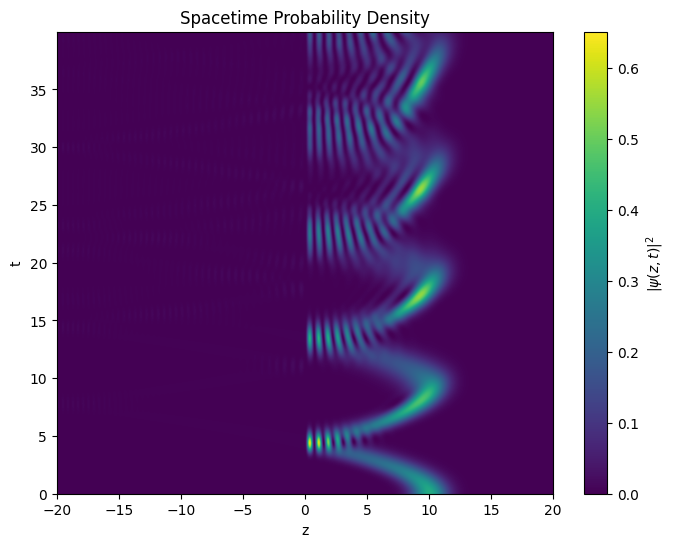

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# ------------------
# 1) Constants & Setup
# ------------------
hbar = 1.0
m = 1.0
g = 1.0

# ------------------
# 2) Potential Functions
# ------------------
def gravity_potential(z):
    return m * g * z

def delta_barrier(z, z0=0.0, alpha=5.0, dz=0.01):
    """Approximate a delta potential by a very narrow Gaussian."""
    sigma = dz / 2
    return alpha * np.exp(-((z - z0)**2)/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def gaussian_barrier(z, z0=0.0, V0=5.0, sigma=0.5):
    """A Gaussian potential barrier centered at z0."""
    return V0 * np.exp(-(z - z0)**2/(2*sigma**2))

# ------------------
# 3) Initial Wavefunction
# ------------------
def initial_wavefunction(z, z0=10.0, p0=0.0, sigma0=1.0):
    """Gaussian wave packet with center z0, momentum p0, width sigma0."""
    norm_factor = 1.0 / (2.0 * np.pi * sigma0**2)**0.25
    return norm_factor \
           * np.exp(-(z - z0)**2 / (4.0 * sigma0**2)) \
           * np.exp(1j * p0 * (z - z0) / hbar)

# ------------------
# 4) Split-Operator Step
# ------------------
def split_operator_step(psi, V, kinetic_factor, dt):
    """Perform one split-operator time step: half potential -> full kinetic -> half potential."""
    # half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)

    # full-step in kinetic (momentum) space
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_factor
    psi = np.fft.ifft(psi_k)

    # another half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    return psi

# ------------------
# 5) Simulation Function
# ------------------
def simulate_n(barrier_type='delta', 
               n_steps=200, 
               dt=0.01, 
               x_min=-20, x_max=20, Nx=512,
               barrier_params=None,
               z0_packet=10.0, p0_packet=0.0):
    """
    Simulate the time evolution for n_steps using split-operator, storing |psi(z,t)|^2 each step.
    Return (z_array, t_vals, prob_arr), where prob_arr[step, :] = |psi(z, t_step)|^2.
    """
    if barrier_params is None:
        barrier_params = {}

    # Spatial grid
    z_array = np.linspace(x_min, x_max, Nx)
    dz = z_array[1] - z_array[0]

    # Barrier potential
    if barrier_type == 'delta':
        V_bar = delta_barrier(z_array, **barrier_params, dz=dz)
    else:
        V_bar = gaussian_barrier(z_array, **barrier_params)

    # Total potential = gravity + barrier
    V_total = gravity_potential(z_array) + V_bar

    # Kinetic factor in momentum space
    k_array = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dz)
    kinetic_factor = np.exp(-0.5j * (hbar * k_array**2 / (2*m)) * (dt / hbar) * 2)

    # Initial wavefunction
    psi = initial_wavefunction(z_array, z0=z0_packet, p0=p0_packet, sigma0=1.0)

    # For storing probability
    prob_arr = np.zeros((n_steps, Nx), dtype=np.float64)

    # Time evolution
    for step in range(n_steps):
        # record |psi|^2 at this step
        prob_arr[step] = np.abs(psi)**2
        # step forward
        psi = split_operator_step(psi, V_total, kinetic_factor, dt)

    # time array
    t_vals = np.arange(n_steps) * dt
    return z_array, t_vals, prob_arr

# ------------------
# 6) 2D Heatmap Plot
# ------------------
def plot_spacetime(prob_arr, z_array, t_vals):
    """
    Produce a heatmap of |psi(z,t)|^2 over space (x-axis) and time (y-axis).
    
    prob_arr : shape (N_time, N_space)
               prob_arr[i, j] = |psi(z_j, t_i)|^2
    z_array  : spatial grid, shape (N_space,)
    t_vals   : time array, shape (N_time,)
    """
    z_min, z_max = z_array[0], z_array[-1]
    t_min, t_max = t_vals[0], t_vals[-1]

    plt.figure(figsize=(8,6))
    plt.imshow(
        prob_arr,
        extent=[z_min, z_max, t_min, t_max],
        aspect='auto',
        cmap='viridis',
        origin='lower'
    )
    plt.colorbar(label=r'$|\psi(z,t)|^2$')
    plt.xlabel('z')
    plt.ylabel('t')
    plt.title('Spacetime Probability Density')
    plt.show()

# ------------------
# 7) Main Execution
# ------------------
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': 15.0}
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='delta',
        n_steps=40000,
        dt=0.001,
        x_min=-20, x_max=20, Nx=512,
        barrier_params=barrier_params_delta,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


What the fuck am I seeing here? Is this a double Helix of kinds? Look at the curves... look at the difraction patterns... you this is increidble... lorentz transformetis/? It's like likst a single helix or something?

Things that come to mind:
- It feels like, starting with a gaussian, when letting go, then it has a chance of bouncing, with high intensitities down the line, at the same exact locatoin as before, hence memory can be stored with higher probability, in a higher probability flux.




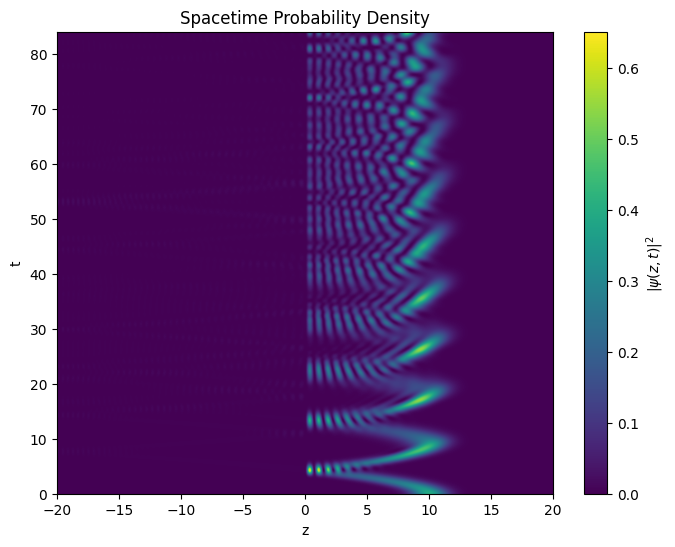

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# ------------------
# 1) Constants & Setup
# ------------------
hbar = 1.0
m = 1.0
g = 1.0

# ------------------
# 2) Potential Functions
# ------------------
def gravity_potential(z):
    return m * g * z

def delta_barrier(z, z0=0.0, alpha=5.0, dz=0.01):
    """Approximate a delta potential by a very narrow Gaussian."""
    sigma = dz / 2
    return alpha * np.exp(-((z - z0)**2)/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def gaussian_barrier(z, z0=0.0, V0=5.0, sigma=0.5):
    """A Gaussian potential barrier centered at z0."""
    return V0 * np.exp(-(z - z0)**2/(2*sigma**2))

# ------------------
# 3) Initial Wavefunction
# ------------------
def initial_wavefunction(z, z0=10.0, p0=0.0, sigma0=1.0):
    """Gaussian wave packet with center z0, momentum p0, width sigma0."""
    norm_factor = 1.0 / (2.0 * np.pi * sigma0**2)**0.25
    return norm_factor \
           * np.exp(-(z - z0)**2 / (4.0 * sigma0**2)) \
           * np.exp(1j * p0 * (z - z0) / hbar)

# ------------------
# 4) Split-Operator Step
# ------------------
def split_operator_step(psi, V, kinetic_factor, dt):
    """Perform one split-operator time step: half potential -> full kinetic -> half potential."""
    # half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)

    # full-step in kinetic (momentum) space
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_factor
    psi = np.fft.ifft(psi_k)

    # another half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    return psi

# ------------------
# 5) Simulation Function
# ------------------
def simulate_n(barrier_type='delta', 
               n_steps=200, 
               dt=0.01, 
               x_min=-20, x_max=20, Nx=512,
               barrier_params=None,
               z0_packet=10.0, p0_packet=0.0):
    """
    Simulate the time evolution for n_steps using split-operator, storing |psi(z,t)|^2 each step.
    Return (z_array, t_vals, prob_arr), where prob_arr[step, :] = |psi(z, t_step)|^2.
    """
    if barrier_params is None:
        barrier_params = {}

    # Spatial grid
    z_array = np.linspace(x_min, x_max, Nx)
    dz = z_array[1] - z_array[0]

    # Barrier potential
    if barrier_type == 'delta':
        V_bar = delta_barrier(z_array, **barrier_params, dz=dz)
    else:
        V_bar = gaussian_barrier(z_array, **barrier_params)

    # Total potential = gravity + barrier
    V_total = gravity_potential(z_array) + V_bar

    # Kinetic factor in momentum space
    k_array = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dz)
    kinetic_factor = np.exp(-0.5j * (hbar * k_array**2 / (2*m)) * (dt / hbar) * 2)

    # Initial wavefunction
    psi = initial_wavefunction(z_array, z0=z0_packet, p0=p0_packet, sigma0=1.0)

    # For storing probability
    prob_arr = np.zeros((n_steps, Nx), dtype=np.float64)

    # Time evolution
    for step in range(n_steps):
        # record |psi|^2 at this step
        prob_arr[step] = np.abs(psi)**2
        # step forward
        psi = split_operator_step(psi, V_total, kinetic_factor, dt)

    # time array
    t_vals = np.arange(n_steps) * dt
    return z_array, t_vals, prob_arr

# ------------------
# 6) 2D Heatmap Plot
# ------------------
def plot_spacetime(prob_arr, z_array, t_vals):
    """
    Produce a heatmap of |psi(z,t)|^2 over space (x-axis) and time (y-axis).
    
    prob_arr : shape (N_time, N_space)
               prob_arr[i, j] = |psi(z_j, t_i)|^2
    z_array  : spatial grid, shape (N_space,)
    t_vals   : time array, shape (N_time,)
    """
    z_min, z_max = z_array[0], z_array[-1]
    t_min, t_max = t_vals[0], t_vals[-1]

    plt.figure(figsize=(8,6))
    plt.imshow(
        prob_arr,
        extent=[z_min, z_max, t_min, t_max],
        aspect='auto',
        cmap='viridis',
        origin='lower'
    )
    plt.colorbar(label=r'$|\psi(z,t)|^2$')
    plt.xlabel('z')
    plt.ylabel('t')
    plt.title('Spacetime Probability Density')
    plt.show()

# ------------------
# 7) Main Execution
# ------------------
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': 15.0}
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='delta',
        n_steps=84000,
        dt=0.001,
        x_min=-20, x_max=20, Nx=512,
        barrier_params=barrier_params_delta,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# Run program
if __name__ == "__main__":
    main()


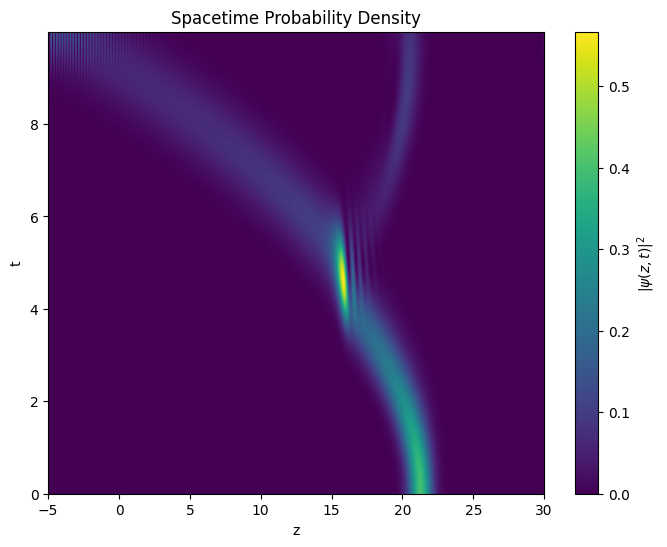

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# ------------------
# 1) Constants & Setup
# ------------------
hbar = 1.0
m = 1.0
g = 1.0

# ------------------
# 2) Potential Functions
# ------------------
def gravity_potential(z):
    return m * g * z

def delta_barrier(z, z0=0.0, alpha=5.0, dz=0.01):
    """Approximate a delta potential by a very narrow Gaussian."""
    sigma = dz / 2
    return alpha * np.exp(-((z - z0)**2)/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def gaussian_barrier(z, z0=0.0, V0=5.0, sigma=0.5):
    """A Gaussian potential barrier centered at z0."""
    return V0 * np.exp(-(z - z0)**2/(2*sigma**2))

# ------------------
# 3) Initial Wavefunction
# ------------------
def initial_wavefunction(z, z0=10.0, p0=0.0, sigma0=1.0):
    """Gaussian wave packet with center z0, momentum p0, width sigma0."""
    norm_factor = 1.0 / (2.0 * np.pi * sigma0**2)**0.25
    return norm_factor \
           * np.exp(-(z - z0)**2 / (4.0 * sigma0**2)) \
           * np.exp(1j * p0 * (z - z0) / hbar)

# ------------------
# 4) Split-Operator Step
# ------------------
def split_operator_step(psi, V, kinetic_factor, dt):
    """Perform one split-operator time step: half potential -> full kinetic -> half potential."""
    # half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)

    # full-step in kinetic (momentum) space
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_factor
    psi = np.fft.ifft(psi_k)

    # another half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    return psi

# ------------------
# 5) Simulation Function
# ------------------
def simulate_n(barrier_type='delta', 
               n_steps=200, 
               dt=0.01, 
               x_min=-20, x_max=20, Nx=512,
               barrier_params=None,
               z0_packet=10.0, p0_packet=0.0):
    """
    Simulate the time evolution for n_steps using split-operator, storing |psi(z,t)|^2 each step.
    Return (z_array, t_vals, prob_arr), where prob_arr[step, :] = |psi(z, t_step)|^2.
    """
    if barrier_params is None:
        barrier_params = {}

    # Spatial grid
    z_array = np.linspace(x_min, x_max, Nx)
    dz = z_array[1] - z_array[0]

    # Barrier potential
    if barrier_type == 'delta':
        V_bar = delta_barrier(z_array, **barrier_params, dz=dz)
    else:
        V_bar = gaussian_barrier(z_array, **barrier_params)

    # Total potential = gravity + barrier
    V_total = gravity_potential(z_array) + V_bar

    # Kinetic factor in momentum space
    k_array = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dz)
    kinetic_factor = np.exp(-0.5j * (hbar * k_array**2 / (2*m)) * (dt / hbar) * 2)

    # Initial wavefunction
    psi = initial_wavefunction(z_array, z0=z0_packet, p0=p0_packet, sigma0=1.0)

    # For storing probability
    prob_arr = np.zeros((n_steps, Nx), dtype=np.float64)

    # Time evolution
    for step in range(n_steps):
        # record |psi|^2 at this step
        prob_arr[step] = np.abs(psi)**2
        # step forward
        psi = split_operator_step(psi, V_total, kinetic_factor, dt)

    # time array
    t_vals = np.arange(n_steps) * dt
    return z_array, t_vals, prob_arr

# ------------------
# 6) 2D Heatmap Plot
# ------------------
def plot_spacetime(prob_arr, z_array, t_vals):
    """
    Produce a heatmap of |psi(z,t)|^2 over space (x-axis) and time (y-axis).
    
    prob_arr : shape (N_time, N_space)
               prob_arr[i, j] = |psi(z_j, t_i)|^2
    z_array  : spatial grid, shape (N_space,)
    t_vals   : time array, shape (N_time,)
    """
    z_min, z_max = -5, z_array[-1]
    t_min, t_max = t_vals[0], t_vals[-1]

    plt.figure(figsize=(8,6))
    plt.imshow(
        prob_arr,
        extent=[z_min, z_max, t_min, t_max],
        aspect='auto',
        cmap='viridis',
        origin='lower'
    )
    plt.colorbar(label=r'$|\psi(z,t)|^2$')
    plt.xlabel('z')
    plt.ylabel('t')
    plt.title('Spacetime Probability Density')
    plt.show()

# ------------------
# 7) Main Execution
# ------------------
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': 15.0}

    # gauss position
    gauss_params = {'z0': 5.0, 'V0': 9.0, 'sigma': 1}

    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=10000,
        dt=0.001,
        x_min=-30, x_max=30, Nx=512,
        barrier_params=gauss_params,
        z0_packet=15.0, # wave position
        p0_packet=0.0 # zero momentum at start
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


Above we see how a gaussian wave with zero starting momentum, receives momentum from g, widens, then bounces partially against a gaussian barrier (reflections) and a part goes through the barrier (transmission).



In [ ]:
a

Above we have a gaussian wave packet, passing easily through the barrier at 5.

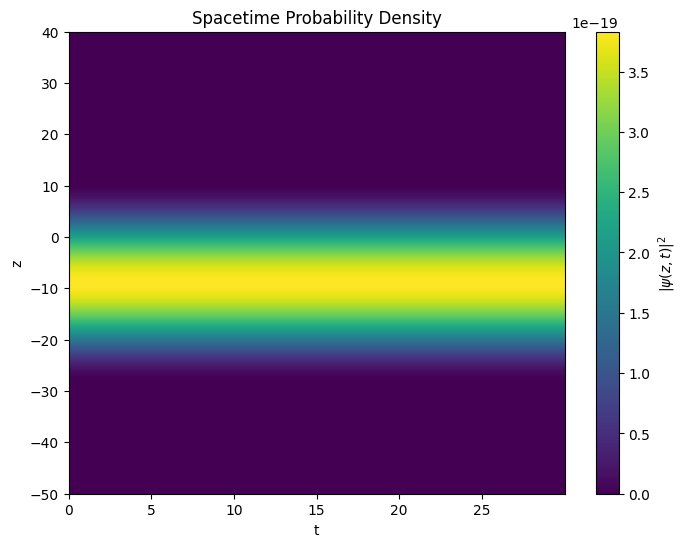

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# ------------------
# 1) Constants & Setup
# ------------------
hbar = 1.0
m = 1.0
g = 1.0

# ------------------
# 2) Potential Functions
# ------------------
def gravity_potential(z):
    return m * g * z

def delta_barrier(z, z0=0.0, alpha=5.0, dz=0.01):
    """Approximate a delta potential by a very narrow Gaussian."""
    sigma = dz / 2
    return alpha * np.exp(-((z - z0)**2)/(2*sigma**2)) / (np.sqrt(2*np.pi)*sigma)

def gaussian_barrier(z, z0=0.0, V0=5.0, sigma=0.5):
    """A Gaussian potential barrier centered at z0."""
    return V0 * np.exp(-(z - z0)**2/(2*sigma**2))

# ------------------
# 3) Initial Wavefunction
# ------------------
def initial_wavefunction(z, z0=10.0, p0=0.0, sigma0=1.0):
    """Gaussian wave packet with center z0, momentum p0, width sigma0."""
    norm_factor = 1.0 / (2.0 * np.pi * sigma0**2)**0.25
    return norm_factor \
           * np.exp(-(z - z0)**2 / (4.0 * sigma0**2)) \
           * np.exp(1j * p0 * (z - z0) / hbar)

# ------------------
# 4) Split-Operator Step
# ------------------
def split_operator_step(psi, V, kinetic_factor, dt):
    """Perform one split-operator time step: half potential -> full kinetic -> half potential."""
    # half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)

    # full-step in kinetic (momentum) space
    psi_k = np.fft.fft(psi)
    psi_k *= kinetic_factor
    psi = np.fft.ifft(psi_k)

    # another half-step in potential
    psi *= np.exp(-0.5j * V * dt / hbar)
    return psi

# ------------------
# 5) Simulation Function
# ------------------
def simulate_n(barrier_type='delta', 
               n_steps=200, 
               dt=0.01, 
               x_min=-20, x_max=20, Nx=512,
               barrier_params=None,
               z0_packet=10.0, p0_packet=0.0):
    """
    Simulate the time evolution for n_steps using split-operator, storing |psi(z,t)|^2 each step.
    Return (z_array, t_vals, prob_arr), where prob_arr[step, :] = |psi(z, t_step)|^2.
    """
    if barrier_params is None:
        barrier_params = {}

    # Spatial grid
    z_array = np.linspace(x_min, x_max, Nx)
    dz = z_array[1] - z_array[0]

    # Barrier potential
    if barrier_type == 'delta':
        V_bar = delta_barrier(z_array, **barrier_params, dz=dz)
    else:
        V_bar = gaussian_barrier(z_array, **barrier_params)

    # Total potential = gravity + barrier
    V_total = gravity_potential(z_array) + V_bar

    # Kinetic factor in momentum space
    k_array = 2.0 * np.pi * np.fft.fftfreq(Nx, d=dz)
    kinetic_factor = np.exp(-0.5j * (hbar * k_array**2 / (2*m)) * (dt / hbar) * 2)

    # Initial wavefunction
    psi = initial_wavefunction(z_array, z0=z0_packet, p0=p0_packet, sigma0=1.0)

    # For storing probability
    prob_arr = np.zeros((n_steps, Nx), dtype=np.float64)

    # Time evolution
    for step in range(n_steps):
        # record |psi|^2 at this step
        prob_arr[step] = np.abs(psi)**2
        # step forward
        psi = split_operator_step(psi, V_total, kinetic_factor, dt)

    # time array
    t_vals = np.arange(n_steps) * dt
    return z_array, t_vals, prob_arr

# ------------------
# 6) 2D Heatmap Plot
# ------------------
def plot_spacetime(prob_arr, z_array, t_vals):
    """
    Produce a heatmap of |psi(z,t)|^2 over time (x-axis) and space (y-axis).
    
    prob_arr : shape (N_time, N_space)
               prob_arr[i, j] = |psi(z_j, t_i)|^2
    z_array  : spatial grid, shape (N_space,)
    t_vals   : time array, shape (N_time,)
    """
    z_min, z_max = z_array[0], z_array[-1]
    t_min, t_max = t_vals[0], t_vals[-1]

    plt.figure(figsize=(8,6))
    plt.imshow(
        prob_arr.T,  # Transpose to switch axes
        extent=[t_min, t_max, z_min, z_max],  # Swap time and space in extent
        aspect='auto',
        cmap='viridis',
        origin='lower'
    )
    plt.colorbar(label=r'$|\psi(z,t)|^2$')
    plt.xlabel('t')
    plt.ylabel('z')
    plt.ylim(-50, z_max)
    plt.title('Spacetime Probability Density')
    plt.show()

# ------------------
# 7) Main Execution
# ------------------
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': 15.0}
    gauss_params = {'z0': 0.0, 'V0': 15.0, 'sigma': 0.1}
    # anim_delta = simulate_n(
    #     barrier_type='gaussian',
    #     n_steps=600,
    #     dt=0.1,
    #     barrier_params=gauss_params,
    #     z0_packet=10.0
    # )
    
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=30000,
        dt=0.001,
        x_min=-50000, x_max=40, Nx=(5*512),
        barrier_params=gauss_params,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


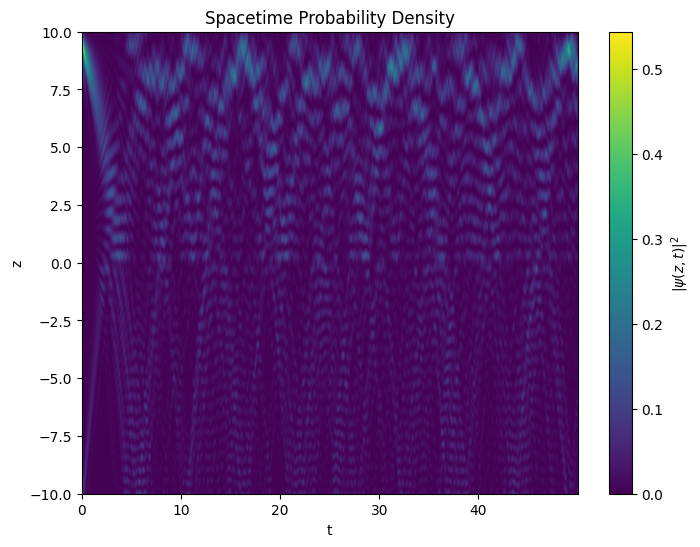

In [110]:
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': .0}
    gauss_params = {'z0': 0.0, 'V0': 15.0, 'sigma': 0.1}
    # anim_delta = simulate_n(
    #     barrier_type='gaussian',
    #     n_steps=600,
    #     dt=0.1,
    #     barrier_params=gauss_params,
    #     z0_packet=10.0
    # )
    
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=10000,
        dt=0.005,
        x_min=-10, x_max=10, Nx=512,
        barrier_params=gauss_params,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


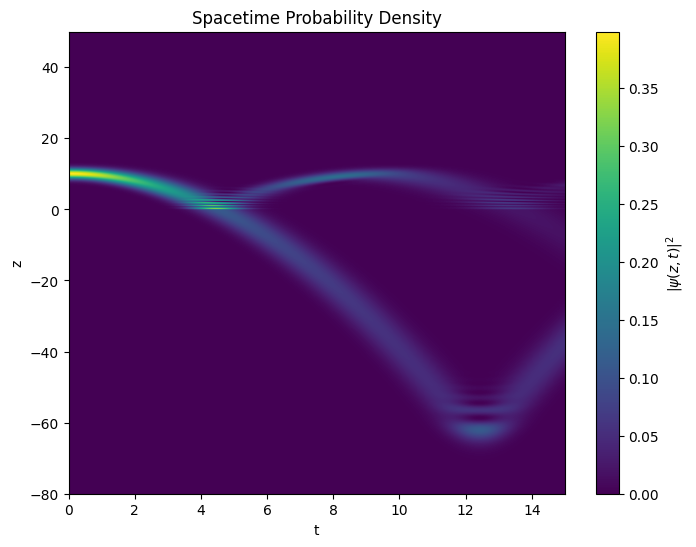

In [120]:
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': .0}
    gauss_params = {'z0': 0.0, 'V0': 15.0, 'sigma': 0.1}
    # anim_delta = simulate_n(
    #     barrier_type='gaussian',
    #     n_steps=600,
    #     dt=0.1,
    #     barrier_params=gauss_params,
    #     z0_packet=10.0
    # )
    
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=1500,
        dt=0.01,
        x_min=-80, x_max=50, Nx=512,
        barrier_params=gauss_params,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


Here we see throughs of the wave packets.

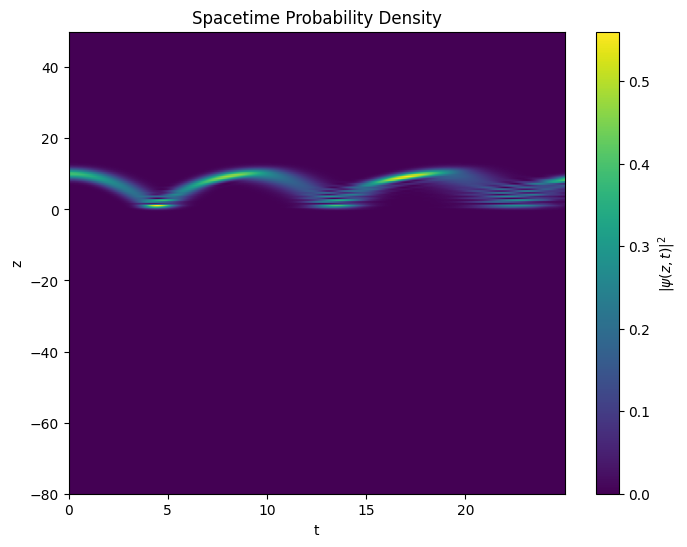

In [163]:
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': .0}
    gauss_params = {'z0': 0.0, 'V0': 15.0, 'sigma': 0.1}
    # anim_delta = simulate_n(
    #     barrier_type='gaussian',
    #     n_steps=600,
    #     dt=0.1,
    #     barrier_params=gauss_params,
    #     z0_packet=10.0
    # )
    
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=2500,
        dt=0.01,
        x_min=-80, x_max=50, Nx=256,
        barrier_params=gauss_params,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


Kinda wandering around right now...

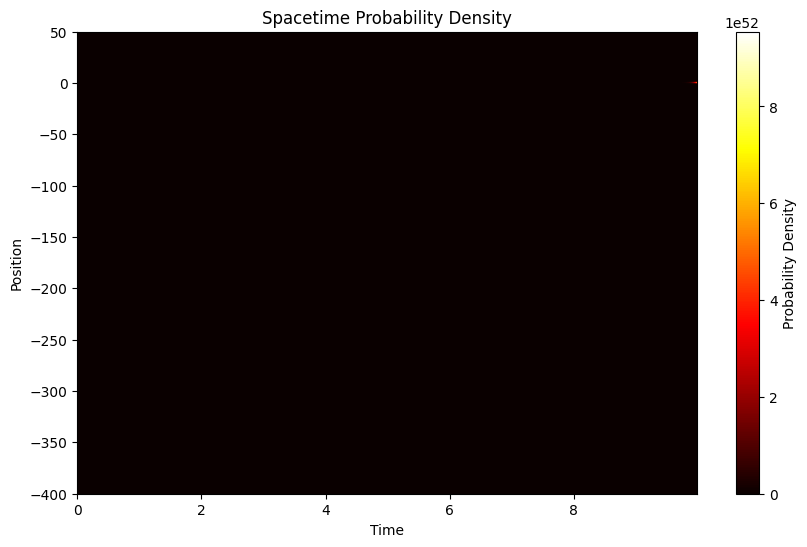

In [10]:
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': .0}
    gauss_params = {'z0': 0.0, 'V0': 10.0, 'sigma': 1}
    # anim_delta = simulate_n(
    #     barrier_type='gaussian',
    #     n_steps=600,
    #     dt=0.1,
    #     barrier_params=gauss_params,
    #     z0_packet=10.0
    # )
    
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=1000,
        dt=0.01,
        x_min=-400, x_max=50, Nx=2000,
        barrier_params=gauss_params,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


In [7]:
def main():
    # Example usage: delta barrier
    barrier_params_delta = {'z0': 0.0, 'alpha': .0}
    gauss_params = {'z0': 0.0, 'V0': 10.0, 'sigma': 1}
    # anim_delta = simulate_n(
    #     barrier_type='gaussian',
    #     n_steps=600,
    #     dt=0.1,
    #     barrier_params=gauss_params,
    #     z0_packet=10.0
    # )
    
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=1000,
        dt=0.01,
        x_min=-400, x_max=50, Nx=2000,
        barrier_params=gauss_params,
        z0_packet=10.0,
        p0_packet=0.0
    )
    
    # Now plot the spacetime density
    plot_spacetime(prob_arr, z_array, t_vals)

# If you want to run it directly here:
if __name__ == "__main__":
    main()


NameError: name 'simulate_n' is not defined

Testing with different boundary conditions or something, to remove simulation artifacts.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_potential(z, z0, V0, sigma):
    """Generate a Gaussian potential."""
    return V0 * np.exp(-((z - z0) ** 2) / (2 * sigma ** 2))

def absorbing_boundary(z_array, width, strength):
    """Create an absorbing boundary condition as a smooth damping function."""
    mask = np.ones_like(z_array)
    left_edge = z_array < (z_array[0] + width)
    right_edge = z_array > (z_array[-1] - width)
    mask[left_edge] = np.exp(-strength * (z_array[left_edge] - z_array[0]) ** 2)
    mask[right_edge] = np.exp(-strength * (z_array[right_edge] - z_array[-1]) ** 2)
    return mask

def initialize_wave_packet(z_array, z0, p0, sigma):
    """Initialize a Gaussian wave packet."""
    norm = (2 * np.pi * sigma ** 2) ** -0.25
    wave_packet = norm * np.exp(-((z_array - z0) ** 2) / (4 * sigma ** 2)) * np.exp(1j * p0 * z_array)
    return wave_packet

def simulate_n(barrier_type, n_steps, dt, x_min, x_max, Nx, barrier_params, z0_packet, p0_packet):
    """Simulate the evolution of a wave packet."""
    z_array = np.linspace(x_min, x_max, Nx)
    dz = z_array[1] - z_array[0]
    psi = initialize_wave_packet(z_array, z0_packet, p0_packet, sigma=1.0)
    
    if barrier_type == 'gaussian':
        V = gaussian_potential(z_array, **barrier_params)
    else:
        V = np.zeros_like(z_array)
    
    absorbing_mask = absorbing_boundary(z_array, width=10.0, strength=0.01)
    h_bar, m = 1.0, 1.0
    k = -h_bar**2 / (2 * m * dz**2)
    laplacian = (-2 * np.eye(Nx) + np.eye(Nx, k=1) + np.eye(Nx, k=-1)) * k
    
    time = np.arange(0, n_steps * dt, dt)
    prob_arr = np.zeros((n_steps, Nx))
    
    for i, t in enumerate(time):
        # Apply the Schrödinger equation
        H = laplacian + np.diag(V)
        psi += -1j * dt / h_bar * H @ psi
        psi *= absorbing_mask  # Apply absorbing boundaries
        
        prob_arr[i, :] = np.abs(psi) ** 2
    
    return z_array, time, prob_arr

def plot_spacetime(prob_arr, z_array, t_vals):
    """Plot the spacetime probability density."""
    plt.figure(figsize=(10, 6))
    plt.imshow(prob_arr.T, extent=[t_vals[0], t_vals[-1], z_array[0], z_array[-1]], 
               origin='lower', aspect='auto', cmap='hot')
    plt.colorbar(label='Probability Density')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Spacetime Probability Density')
    plt.show()

def main():
    barrier_params_gaussian = {'z0': 0.0, 'V0': 30.0, 'sigma': 1}
    z_array, t_vals, prob_arr = simulate_n(
        barrier_type='gaussian',
        n_steps=500,
        dt=0.01,
        x_min=-100, x_max=100, Nx=2000,
        barrier_params=barrier_params_gaussian,
        z0_packet=10.0,
        p0_packet=0.0
    )
    plot_spacetime(prob_arr, z_array, t_vals)

if __name__ == "__main__":
    main()


/var/folders/yj/gnbff_r55s7fw6ylhj7q526r0000gn/T/ipykernel_67694/1915446122.py:48: RuntimeWarning: overflow encountered in square
  prob_arr[i, :] = np.abs(psi) ** 2


OverflowError: cannot convert float infinity to integer

<Figure size 1000x600 with 2 Axes>